In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../../data/annotated',
                                  '../../data/patch_train.csv',
                                  concat=True,
                                  patched=True
                                  )

In [3]:
len(data_set)

1336

torch.Size([6, 256, 256]) torch.Size([256, 256])


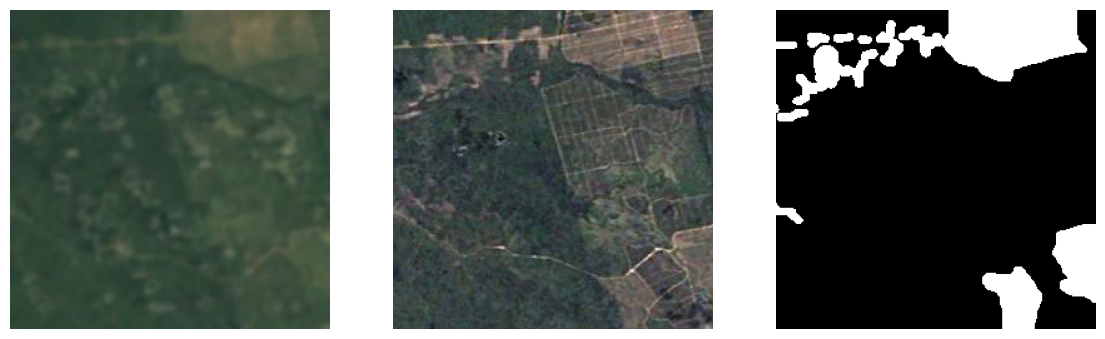

In [4]:
img, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(img.shape, label.shape)

In [5]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(34, 9)

### Modeling

In [6]:
model = FCFE(6, 3, classes=2)

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=10)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [8]:
compiled.summary((6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             880
       BatchNorm2d-2         [-1, 16, 256, 256]              32
           Dropout-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
           Dropout-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
       BatchNorm2d-9         [-1, 32, 128, 128]              64
          Dropout-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
          Dropout-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,


(dot.exe:5836): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


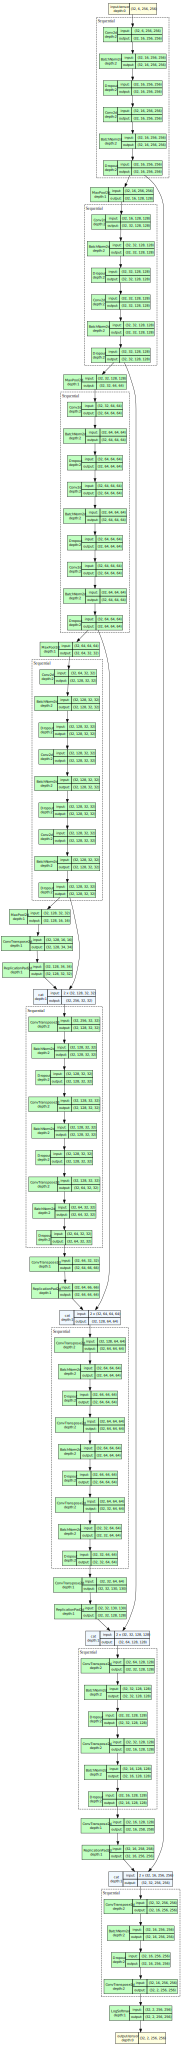

In [9]:
compiled.visual_graph((32, 6, 256, 256))

In [ ]:
w = torch.load('../../data/class_weight.pt')
w

In [10]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(torch.FloatTensor([0.0962, 0.2]).cuda()),
                         100,
                         test_dataloader)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100
train loss: 0.7919516843907973
val loss: 0.6593662103017172
Epoch: 1/100
train loss: 0.5635372461641536
val loss: 0.971981922785441
Epoch: 2/100
train loss: 0.41027972277473
val loss: 0.42096075415611267
Epoch: 3/100
train loss: 0.31333207645836997
val loss: 0.27735119064648944
Epoch: 4/100
train loss: 0.2864695520085447
val loss: 0.2933848748604457
Epoch: 5/100
train loss: 0.2834162256296943
val loss: 0.6542747682995267
Epoch: 6/100
train loss: 0.2773013895048815
val loss: 0.2829607278108597
Epoch: 7/100
train loss: 0.2649886156706249
val loss: 0.2846139901214176
Epoch: 8/100
train loss: 0.26099154396968727
val loss: 0.30797653728061253
Epoch: 9/100
train loss: 0.2508072826792212
val loss: 0.2605879207452138
Epoch: 10/100
train loss: 0.24084115510477738
val loss: 0.27041560577021706
Epoch: 11/100
train loss: 0.24179262974682977
val loss: 0.27705712285306716
Epoch: 12/100
train loss: 0.2379515973084113
val loss: 0.2807962761984931
Epoch: 13/100
train loss: 0.23213449295829

In [79]:
# restore best checkpoint
state = torch.load("./last-checkpoint.pth")
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

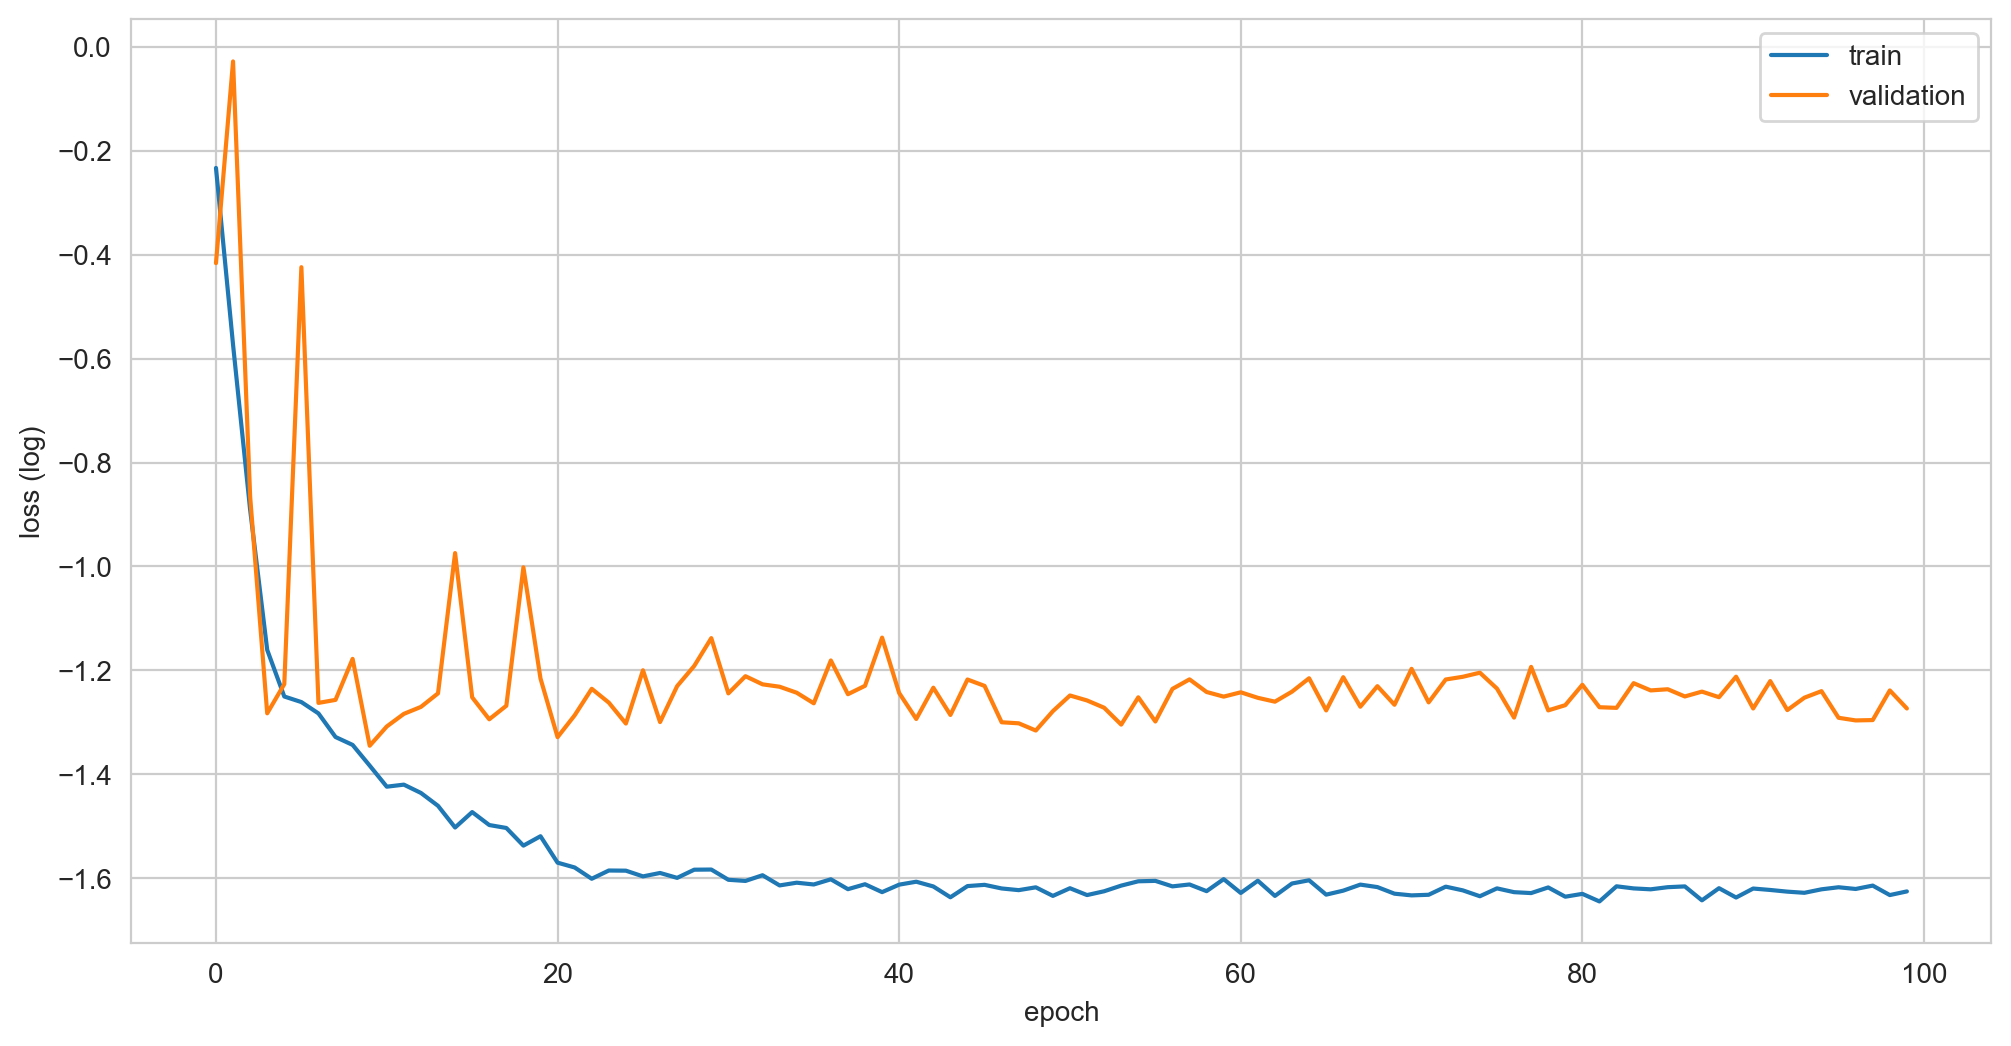

In [11]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(x=results['epoch'], y=np.log(results['train loss']), label='train')
sns.lineplot(x=results['epoch'], y=np.log(results['val loss']), label='validation')
plt.ylabel('loss (log)')
plt.show()

In [14]:
acc_test = 0
kappa_test = 0
dice_test = 0
recall_test = 0
precision_test = 0

for img, gt in tqdm(test_dataset):
    with torch.no_grad():
        model.eval()
        logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
        pred = torch.argmax(torch.sigmoid(logits), dim=0)

    acc_test += pixel_accuracy(gt, pred)
    kappa_test += precision(gt, pred)
    dice_test += dice(gt, pred)
    recall_test += recall(gt, pred)
    precision_test += precision(gt, pred)

print(acc_test / len(test_dataset),
      kappa_test / len(test_dataset),
      dice_test / len(test_dataset),
      recall_test / len(test_dataset),
      precision_test / len(test_dataset))

  0%|          | 0/268 [00:00<?, ?it/s]

tensor(0.9142) tensor(nan) tensor(nan) tensor(nan) tensor(nan)


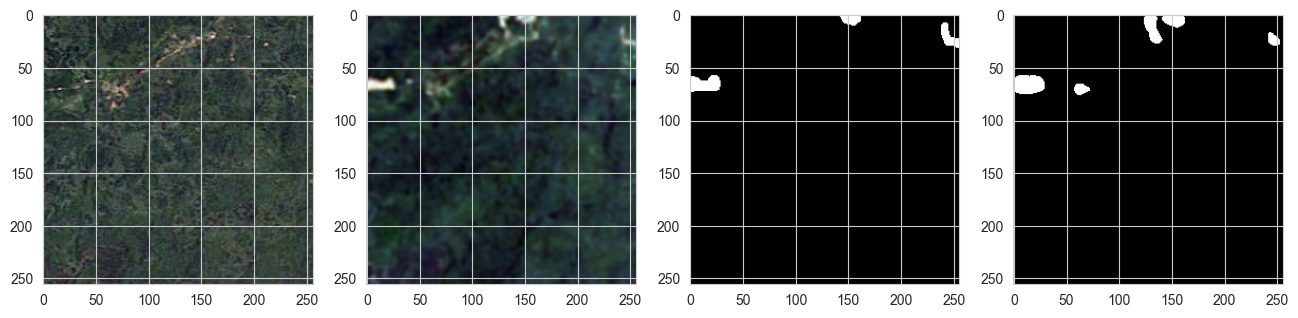

In [19]:
img, gt = test_dataset[np.random.randint(0, len(test_dataset))]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[:3, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(img[3:, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')